# Example: Grid Analysis Results

Last Verified to Run: 2021-07-08<br>
Verified Stack Release: v21.0.0

## Introduction

The purpose of this notebook is to demonstrate the methodology behind the sensor distortion analysis using an dataset of projected spot grid images, as well as to serve as a tutorial for exploring these results by interacting with a Gen 3 Repository. The data products shown here were generated by running the `mixcoatl.characterizeSpots.CharacterizeSpotsTask`, `mixcoatl.gridFitTask.GridFitTask`, and `mixcotal.gridCalibrationTask.GridCalibrationTask`, using the pipetask YAML file `gridAnalysis.yaml` found in `mixcoatl/pipelines`.

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+8459b0669c 	w_2021_20 w_latest current setup


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np

## DM Stack imports
from lsst.daf.butler import Butler

## MixCOATL imports
from mixcoatl.sourcegrid import DistortedGrid

## Gen 3 repo (spot grid image data only)
repo = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml'

## Exploring a Gen 3 Repository

A Butler object can be initialized using the filepath to the repository YAML file. The LSSTCam BOT Gen 3 repository is located on the SLAC SDF, and is split between a number of smaller repositories.  The repository containing the datasets corresponding to the spot grid data acquisition runs during the nine-raft testing period is located at `/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/`. While the Butler itself is used for retrieving a dataset from the repository, the registry is useful for performing queries on datasets, exploring "collections" of datasets, and determining dataset types.

In [3]:
butler = Butler(repo)
registry = butler.registry

Here the registry is used to query all the "collections" within the repository and print a sub-set of relevant collections.

In [4]:
## Display collections in the repository
for collection in registry.queryCollections():
    print(collection)

LSSTCam/raw/all
u/youtsumi/calib/bias/run_6806D
u/youtsumi/calib/bias/run_6806D/20210522T012232Z
/calib/run_6806D
LSSTCam/calib
LSSTCam/calib/unbounded
u/youtsumi/calib/dark/run_6806D
u/youtsumi/calib/dark/run_6806D/20210522T174047Z
u/youtsumi/calib/dark/run_6806D/20210522T175400Z
u/youtsumi/calib/defects/run_6806D
u/youtsumi/calib/defects/run_6806D/20210522T201601Z
u/youtsumi/calib/defects/run_6806D/20210522T203525Z
u/youtsumi/calib/defects/run_6806D/20210522T204002Z
u/youtsumi/spot/1st
u/youtsumi/spot/1st/20210523T023357Z
u/abrought/spot/6864d
u/abrought/spot/6864d/20210526T162737Z
u/abrought/calib/bias/run_6806D
u/abrought/calib/bias/run_6806D/20210526T170628Z
u/abrought/calib/bias/run_6806D/20210526T182322Z
/calib/alex/run_6806D
u/abrought/spot/6864D_allspots
u/abrought/spot/6864D_allspots/20210526T231202Z
u/abrought/spot/6864D_allspots/20210526T232253Z
u/abrought/spot/6864D_allspots/20210526T232908Z
u/abrought/spot/6864D_allspots/20210526T233224Z
u/abrought/spot/6864D_spots_R22S11

In this notebook we will focus on the collections `u/asnyder/spot/itl_analysis` and `u/asnyder/spot/itl_calibration` that contain the initial grid analysis results and the final grid calibration results respectively for an ITL CCD.

The registry can also be used to display the dataset types that have been registered with in the repository.

In [5]:
## Display dataset types in repository
for dataset in registry.queryDatasetTypes():
    print(dataset)

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('cpCombine_config', {}, Config)
DatasetType('packages', {}, Packages)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('cpDarkCombine_metad

This repository contains the raw images (`raw`), camera information (`camera`), the calibrated images (`postISRCCD`), the original source catalogs (`spotSrc`), the processed (`gridSpotSrc`) source catalogs, and the final grid calibration (`gridCalibration`). Additionally there is Task metadata and Task configuration information for the analysis runs.

Before beginning to query the repository for these datasets, it is useful to know the queryable properties of the datasets. The fields used when querying for an exposure are:

In [6]:
## Display list of dataset fields
print(registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  day_obs: int
  seq_num: int
  group_name: str
  group_id: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  zenith_angle: float
  timespan: lsst.daf.butler.Timespan


## Grid Analysis Results

To obtain the results corresponding to the analysis run on the data from Run 6865D, first the dataset references for the calibrated images within the corresponding collection are obtained using the registry, by specifying the dataset type and the collection.

In [7]:
datasetRefs = list(registry.queryDatasets('postISRCCD', collections='u/asnyder/spot/itl_analysis'))
print('Number of calibrated images: {0}'.format(len(datasetRefs)))

Number of calibrated images: 1600


An example of a single calibrated image is shown below; this run consisted of an analysis of spot grid images where the projected grid was randomly dithered across a single ITL CCD. Because of the nature of the projector optics, the outer regions of the spot grid suffer from vignetting and other optical distortions. In order to make the full grid visible, a symmetric logarithmic color scale is used that is linear between +/- 10 and logarithmic elsewhere.

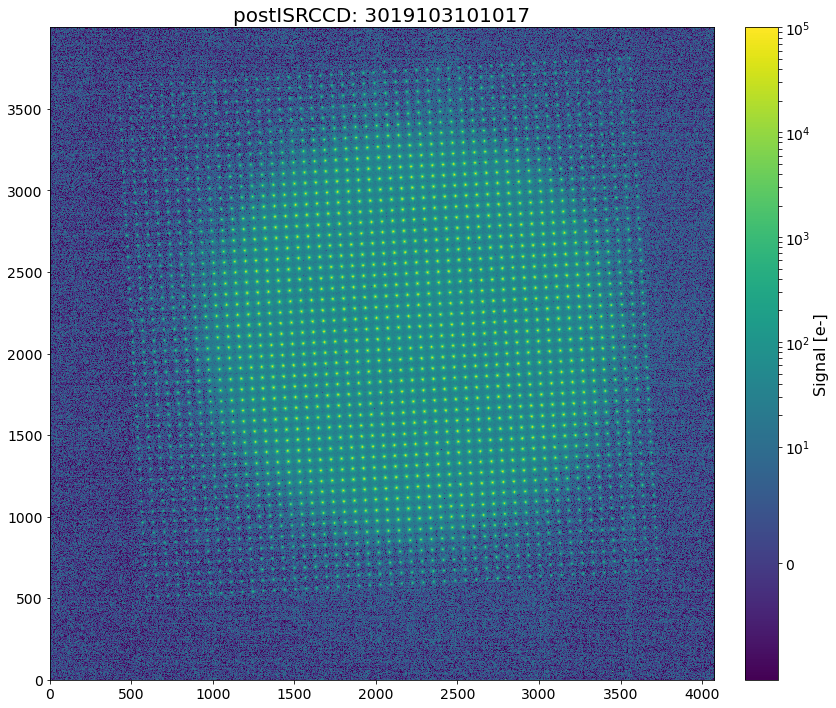

In [8]:
ref = datasetRefs[1000]
calexp = butler.get(ref, collections='u/asnyder/spot/itl_analysis')

## Display calibrated image
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
im = ax.imshow(calexp.getImage().getArray(), interpolation='none', origin='lower', 
               norm=SymLogNorm(10, vmin=-10, vmax=100000, base=10))
    
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [e-]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('postISRCCD: {0}'.format(ref.dataId['exposure']), fontsize=20)
fig.patch.set_facecolor('white')

Initial analysis of the calibrated image, performed by `mixcoatl.characterizeSpots.CharacterizeSpotsTask` results in a a source catalog of datatype `spotSrc`, that contains information for each of the identified sources. This can be viewed easily by converting to an `astropy.table.Table`.

In [9]:
source_catalog = butler.get('spotSrc', dataId=ref.dataId, collections='u/asnyder/spot/itl_analysis')

source_catalog.asAstropy()

id,coord_ra,coord_dec,parent,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeBj_flag_badCentroid,ext_shapeHSM_HsmShapeKsb_flag_badCentroid,ext_shapeHSM_HsmShapeLinear_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeBj_flag_badCentroid_edge,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_edge,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeBj_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeBj_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmShapeBj_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmShapeBj_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,ext_shapeHSM_HsmPsfMoments_flag_badCe

Column data can be obtained from the source catalog by using the table column name. Below, the source positions determined using the SDSS measurement algorithm are used to scatter plot the detected sources from the calibrated image, while the color indicating a summed flux value for each spot.

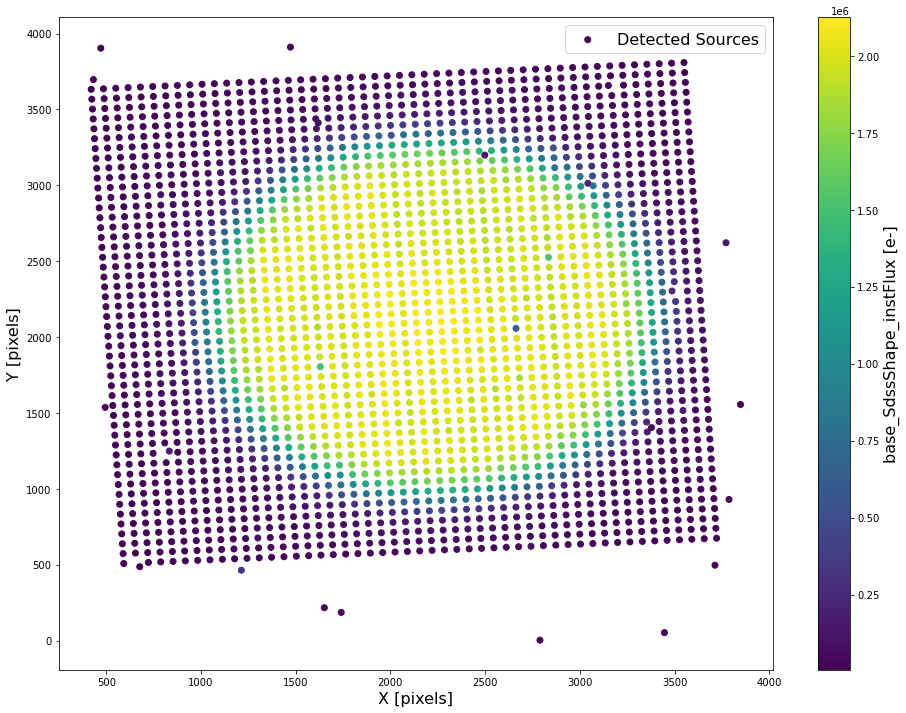

In [10]:
src_y = source_catalog['base_SdssCentroid_y']
src_x = source_catalog['base_SdssCentroid_x']
src_flux = source_catalog['base_SdssShape_instFlux']

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
im = ax.scatter(src_x, src_y, c=src_flux, label='Detected Sources')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('base_SdssShape_instFlux [e-]', fontsize=16)
ax.legend(fontsize=16)
ax.set_ylabel('Y [pixels]', fontsize=16)
ax.set_xlabel('X [pixels]', fontsize=16)
fig.patch.set_facecolor('white')

Following the grid fit analysis performed by `mixcoatl.gridFitTask.GridFitTask`, new catalogs of dataset type `gridSpotSrc` are produced that contain all the original information, but append a set of new columns following the determination of the best fit model of an ideal grid to the detected sources.  

The column `spotgrid_index` is useful to determine which detected sources have been properly matched to a correspond source in the 49 by 49 projected grid; a matched source will have an index between 0 and 2400.  The above plot is reproduced using this column to select only the matched spots.

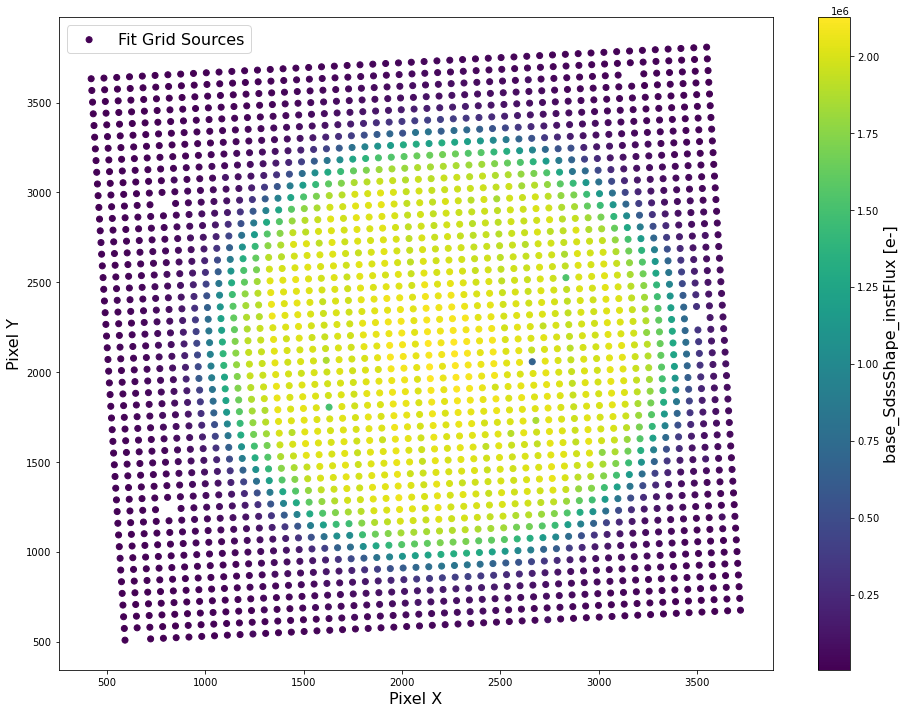

In [11]:
fit_catalog = butler.get('gridSpotSrc', dataId=ref.dataId, collections='u/asnyder/spot/itl_analysis')

select = fit_catalog['spotgrid_index'] >= 0.

fit_src_y = fit_catalog['base_SdssCentroid_y'][select]
fit_src_x = fit_catalog['base_SdssCentroid_x'][select]
fit_src_flux = source_catalog['base_SdssShape_instFlux'][select]

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.scatter(fit_src_x, fit_src_y, c=fit_src_flux, label='Fit Grid Sources')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('base_SdssShape_instFlux [e-]', fontsize=16)
ax.legend(fontsize=16)
ax.set_ylabel('Pixel Y', fontsize=16)
ax.set_xlabel('Pixel X', fontsize=16)
fig.patch.set_facecolor('white')

Additionally, the processed catalogs will contain information regarding the parameters of the best fit ideal grid model.  This information is stored in the catalog metadata, and can be obtained as follows:

In [12]:
metadata = fit_catalog.getMetadata()
print(metadata)

BASE_CIRCULARAPERTUREFLUX_RADII = [ 3.0000000000000, 4.5000000000000, 6.0000000000000, 9.0000000000000, 12.000000000000, 17.000000000000, 25.000000000000, 35.000000000000, 50.000000000000, 70.000000000000 ]
NOISE_SEED_MULTIPLIER = 1
NOISE_SOURCE = "measure"
NOISE_OFFSET = 0.0000000000000
NOISE_EXPOSURE_ID = 0
BOTXCAM = -294.20799117660
BOTYCAM = 41.699999418640
GRID_X0 = 2069.2821737399
GRID_Y0 = 2156.0186146362
GRID_THETA = 0.054849990586311
GRID_XSTEP = 65.309976096460
GRID_YSTEP = 65.321869003273
GRID_NCOLS = 49
GRID_NROWS = 49



## Grid Calibration Results

Determination of the component of the flux, position, or shape distortions to the projected grid sources caused by optics or mask imperfections is performed by taking the per-spot average of each property over a large number of images where the grid is dithered across the CCD. This averaging process is done using `mixcoatl.gridCalibrationTask.GridCalibrationTask` and produces an `astropy.table.Table` that acts as a calibration table for the projected grid.

In [13]:
ref = list(registry.queryDatasets('gridCalibration', collections='u/asnyder/spot/itl_calibration'))[0]

calib_table = butler.get(ref, collections='u/asnyder/spot/itl_calibration')

calib_table

spotgrid_index,spotgrid_normalized_dy,spotgrid_normalized_dx,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,ext_shapeHSM_HsmPsfMoments_x,ext_shapeHSM_HsmPsfMoments_y,ext_shapeHSM_HsmPsfMoments_xx,ext_shapeHSM_HsmPsfMoments_yy,ext_shapeHSM_HsmPsfMoments_xy,ext_shapeHSM_HsmShapeBj_e1,ext_shapeHSM_HsmShapeBj_e2,ext_shapeHSM_HsmShapeBj_sigma,ext_shapeHSM_HsmShapeBj_resolution,ext_shapeHSM_HsmShapeKsb_g1,ext_shapeHSM_HsmShapeKsb_g2,ext_shapeHSM_HsmShapeKsb_sigma,ext_shapeHSM_HsmShapeKsb_resolution,ext_shapeHSM_HsmShapeLinear_e1,ext_shapeHSM_HsmShapeLinear_e2,ext_shapeHSM_HsmShapeLinear_sigma,ext_shapeHSM_HsmShapeLinear_resolution,ext_shapeHSM_HsmShapeRegauss_e1,ext_shapeHSM_HsmShapeRegauss_e2,ext_shapeHSM_HsmShapeRegauss_sigma,ext_shapeHSM_HsmShapeRegauss_resolution,ext_shapeHSM_HsmSourceMoments_x,ext_shapeHSM_HsmSourceMoments_y,ext_shapeHSM_HsmSourceMoments_xx,ext_shapeHSM_HsmSourceMoments_yy,ext_shapeHSM_HsmSourceMoments_xy,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_12_0_instFlux,base_CircularApertureFlux_12_0_instFluxErr,base_CircularApertureFlux_17_0_instFlux,base_CircularApertureFlux_17_0_instFluxErr,base_CircularApertureFlux_25_0_instFlux,base_CircularApertureFlux_25_0_instFluxErr,base_CircularApertureFlux_35_0_instFlux,base_CircularApertureFlux_35_0_instFluxErr,base_CircularApertureFlux_50_0_instFlux,base_CircularApertureFlux_50_0_instFluxErr,base_CircularApertureFlux_70_0_instFlux,base_CircularApertureFlux_70_0_instFluxErr,base_GaussianFlux_instFlux,base_GaussianFlux_instFluxErr,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_area,base_ClassificationExtendedness_value,base_FootprintArea_value
,,,pix,pix,pix2,pix2,pix2,pix2,pix2,pix2,pix,pix,ct,ct,pix2,pix2,pix2,ct pix2,ct pix2,ct pix2,pix,pix,pix2,pix2,pix2,,,,,,,,,,,,,,,,,pix,pix,pix2,pix2,pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,pix,,pix
int32,float64,float64,float32,float32,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
0,0.04897568506698473,0.03665226936656039,0.12827264,0.1291484,5.74404913857055,5.8460245892371745,0.3900160784014212,0.28971946,0.20714606,0.29487416,586.8760928382427,344.2850270392508,8343.514741257546,210.31335103397328,2.2499447646141095,2.2499447646141095,0.0,-30.485891,-2.0672245,-31.031193,-5.614106030549762e-05,-5.614106029566276e-05,2.2494517898741293,2.2494517898741293,-4.3345583313119626e-18,-0.014673967880825353,0.11755802992934587,0.03067244462355245,0.6121131612684033,-0.007517996830070828,0.05897784951452614,0.01538770917137229,0.6104834364999521,-0.014729506528806906,0.1179928967176453,0.03067244462355245,0.6121131612684033,-0.014686701619675297,0.11731163362501361,0.029304662213125644,0.6122821999969651,586.9366374272686,344.3159167558763,5.747361144703288,5.845948637857013,0.39100232915090066,4623.853344095941,80.32258657758086,6841.1824654

A `mixcoatl.sourcegrid.DistortedGrid` objects gives an useful interface for extracting information about the calibrated centroid shifts of each spot from the ideal grid model position. This is useful because the centroid shifts stored in the original calibration table are normalized in such a way to preserve their value under magnification or rotation of the source grid.

The calibrated centroid shifts of the projected grid of spots is plotted below using a quiver plot.

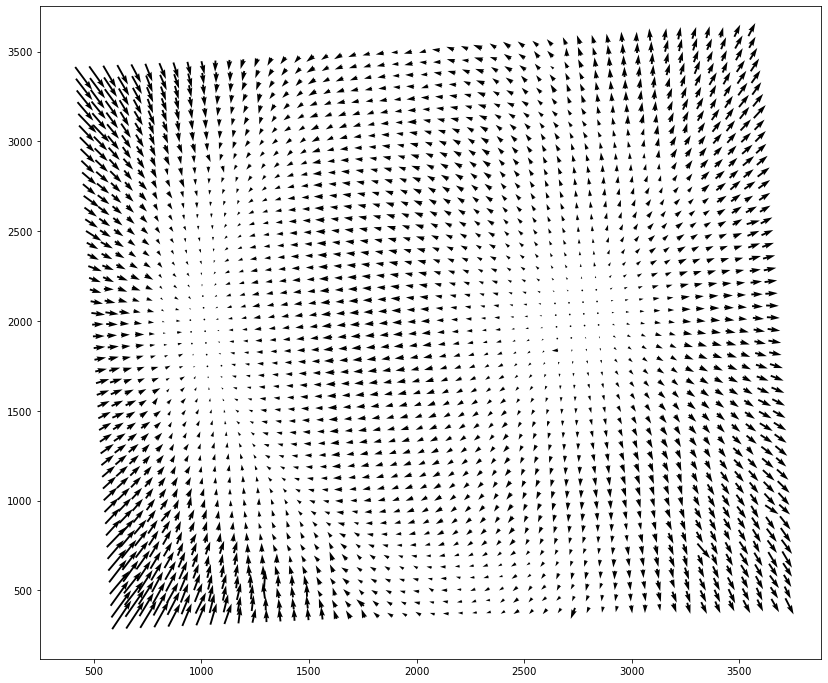

In [14]:
grid = DistortedGrid.from_astropy(calib_table)
y, x = grid.get_centroids()
dy, dx = grid.get_centroid_shifts()

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.quiver(x, y, dx, dy)

This can be combined with the calibrated second moment measurements of each spot.

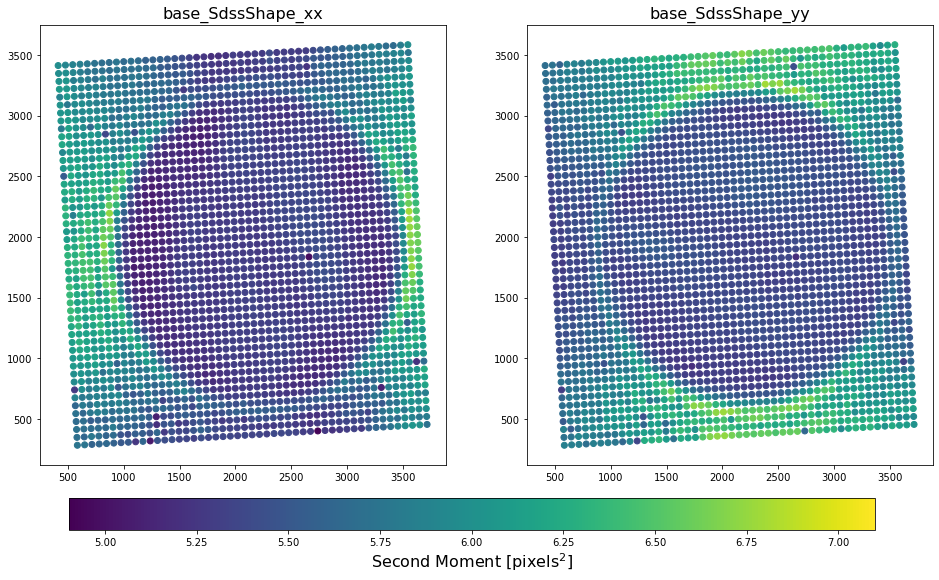

In [15]:
xx = calib_table['base_SdssShape_xx']
yy = calib_table['base_SdssShape_yy']

fig, ax = plt.subplots(1, 2, figsize=(16, 9))
im0 = ax[0].scatter(x, y, c=xx, vmin=4.9, vmax=7.1)
im1 = ax[1].scatter(x, y, c=yy, vmin=4.9, vmax=7.1)
ax[0].set_title('base_SdssShape_xx', fontsize=16)
ax[1].set_title('base_SdssShape_yy', fontsize=16)
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.05])
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'Second Moment [$\mathrm{pixels}^2$]', fontsize=16)